# High-resolution spectra

Let's set up an atmosphere as in the ["Getting Started"](getting_started.html) example, but this time for high-resolution spectra:

In [1]:
import numpy as np
from petitRADTRANS.radtrans import Radtrans

atmosphere = Radtrans(pressures = np.logspace(-10,2,130),
                      line_species = ['1H2-16O',
                                      '12C-16O'],
                      rayleigh_species = ['H2', 'He'],
                      gas_continuum_contributors = ['H2-H2', 'H2-He'],
                      wavelength_boundaries = [2.2, 2.4],
                      line_opacity_mode = 'lbl')

Loading Radtrans opacities...
 Loading line opacities of species '1H2-16O' from file '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/line_by_line/H2O/1H2-16O/1H2-16O__HITEMP.R1e6_0.3-28mu.xsec.petitRADTRANS.h5'... Done.
 Loading line opacities of species '12C-16O' from file '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/line_by_line/CO/12C-16O/12C-16O__HITRAN.R1e6_0.3-28mu.xsec.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/Users/molliere/Desktop/input_data_v3/input_data/opacities/continuum/collision_induced_absorptions/H2--H2/H2--H2-NatAbund/H2--H2-NatAbund__BoRi.R831_0.6-250mu.ciatable.petitRADTRANS.h5'... Done.
 Loading CIA opacities for H2-He from file '/Users/molliere/Desktop/input_data_v3/input_data/opacities/continuum/collision_induced_absorptions/H2--He/H2--He-NatAbund/H2--He-NatAbund__BoRi.DeltaWavenumber2_0.5-500mu.ciatable.petitRADTRANS.h5'... Done.
 Successfully loaded all 

Here we included only water and carbon monoxide, as only those play a role for the abundances and wavelength range chosen here.

<div class="alert alert-warning">

**Units in petitRADTRANS:** all units inside *petitRADTRANS* are in cgs. However, when interfacing with the code, you are expected to provide pressures in bars (more intuitive). Pressures will be converted to cgs units within the code.
</div>

Note: here we directly addressed which isotopologues we wanted to consider, when loading the opacities see "[available opacities](../available_opacities.html)" for a full list of avialable species. Note that we also could have written `line_species = ['H2O', 'CO']`, in this case pRT loads the main isotopologues, which is also what we requested specifically above. In addition, we have invoked the high resolution mode by setting the keyword argument `line_opacity_mode` to `'lbl'`, which stands for line-by-line. We also loaded a smaller wavelength range, because the high-resolution opacities are pretty big...

We define the planetary radius and gravity at reference pressure $P_0$, as well as the temperatures, abundances and mean molecular weight like before, see ["Getting Started"](getting_started.html) for more information:

In [2]:
from petitRADTRANS import physical_constants as cst
from petitRADTRANS.physics import temperature_profile_function_guillot_global

planet_radius = 1.0*cst.r_jup_mean
reference_gravity = 10**3.5
reference_pressure = 0.01

pressures_bar = atmosphere.pressures*1e-6 # cgs to bar
kappa_IR = 0.01
gamma = 0.4
T_int = 200.
T_equ = 1500.

temperatures = temperature_profile_function_guillot_global(pressures_bar, kappa_IR, gamma, reference_gravity, T_int, T_equ)


mass_fractions = {}
mass_fractions['H2'] = 0.74 * np.ones_like(temperatures)
mass_fractions['He'] = 0.24 * np.ones_like(temperatures)
mass_fractions['1H2-16O'] = 1e-3 * np.ones_like(temperatures)
mass_fractions['12C-16O'] = 1e-2 * np.ones_like(temperatures)

            #  2.33 is a typical value for H2-He dominated atmospheres
mean_molar_masses = 2.33 * np.ones_like(temperatures)

<div class="alert alert-warning">

**Abundances in petitRADTRANS:** abundances in pRT are in units of **mass fractions**, not number fractions (aka volume mixing ratio, VMR). One can convert between mass fractions and VMRs by using
\begin{equation}
X_i = \frac{\mu_i}{\mu}n_i,
\end{equation}
where $X_i$ is the mass fraction of species $i$, $\mu_i$ the molar mass of a molecule/atom/ion/... of species $i$, $\mu$ is the atmospheric mean molar mass, and $n_i$ is the VMR of species $i$. This is implemented in `petitRADTRANS.chemistry.utils.mass_fractions2volume_mixing_ratios()` and `petitRADTRANS.chemistry.utils.volume_mixing_ratios2mass_fractions()`.

</div>

Now, let's calculate and plot the transmission spectrum:

Text(0, 0.5, 'Transit radius [$\\rm R_{Jup}$]')

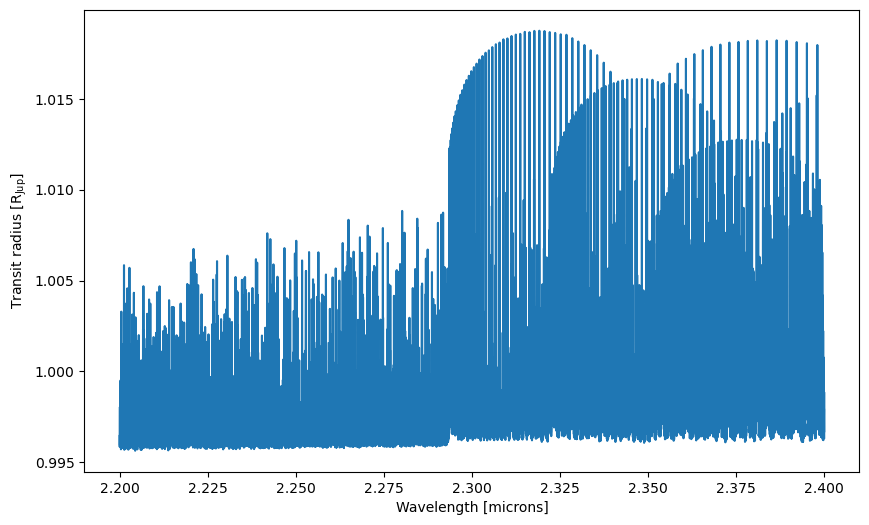

In [3]:
wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(temperatures=temperatures, 
                                                                   mass_fractions=mass_fractions, 
                                                                   mean_molar_masses=mean_molar_masses, 
                                                                   reference_gravity=reference_gravity, 
                                                                   planet_radius=planet_radius, 
                                                                   reference_pressure=reference_pressure)

import pylab as plt
plt.rcParams['figure.figsize'] = (10, 6)

plt.plot(wavelengths*1e4, transit_radii/cst.r_jup_mean)
plt.xlabel('Wavelength [microns]')
plt.ylabel(r'Transit radius [$\rm R_{Jup}$]')

Let's zoom-in a bit, to see individual lines

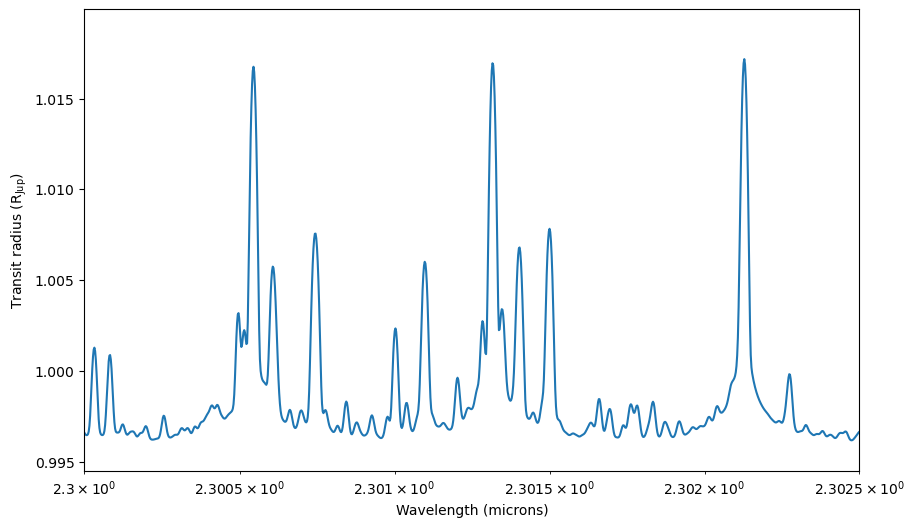

<Figure size 1000x600 with 0 Axes>

In [4]:
plt.plot(wavelengths*1e4, transit_radii/cst.r_jup_mean)

plt.xlim([2.3,2.3025])
plt.xscale('log')
plt.xlabel('Wavelength (microns)')
plt.ylabel(r'Transit radius ($\rm R_{Jup}$)')
plt.show()
plt.clf()

As before, the flux can be calculated like this

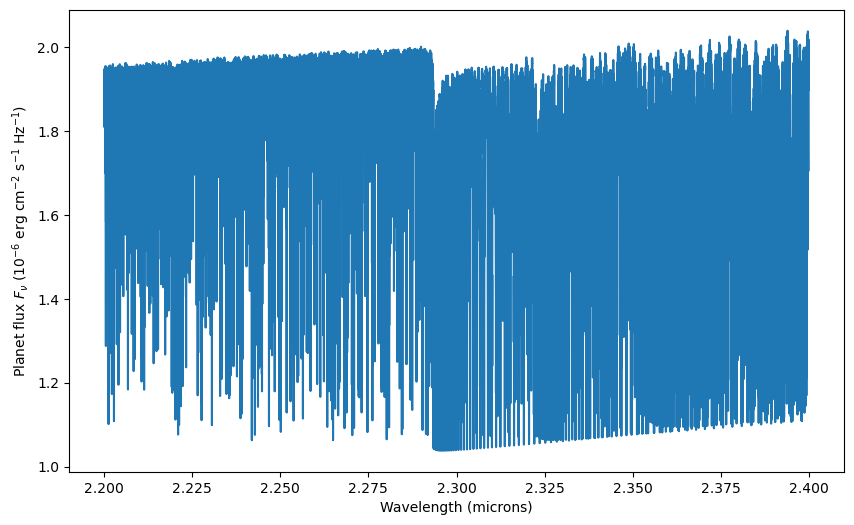

In [5]:
frequencies, flux, _ = atmosphere.calculate_flux(temperatures=temperatures, 
                                                 mass_fractions=mass_fractions, 
                                                 mean_molar_masses = mean_molar_masses,
                                                 reference_gravity = reference_gravity,
                                                 frequencies_to_wavelengths=False)

plt.plot(cst.c/frequencies/1e-4, flux/1e-6)

plt.xlabel('Wavelength (microns)')
plt.ylabel(r'Planet flux $F_\nu$ (10$^{-6}$ erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$)')
plt.show()

<div class="alert alert-warning">

**Standard flux units:** before pRT3 flux was accessed as `atmosphere.flux` after running `atmosphere.calc_flux()`, which contained flux as $F_\nu$, so in units of erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$. pRT's `calculate_flux()` method now returns wavelength and flux as $F_\lambda$ in its standard setting, so flux in erg cm$^{-2}$ s$^{-1}$ cm$^{-1}$. To return frequencies and $F_\nu$, instead of wavelengths and $F_\lambda$, please set the keyword `frequencies_to_wavelengths=False` when calling `calculate_flux()`. **This is also what we did in the example above.**

</div>

<div class="alert alert-warning">

**Scattering and petitRADTRANS:** remember that scattering is included for emission spectra in petitRADTRANS only if requested specifically when generating the Radtrans object, as it increases the runtime (see ["Scattering for Emission Spectra"](emis_scat.html) for an example how to do this). We neglect the scattering here.

</div>

Zooming in here as well:

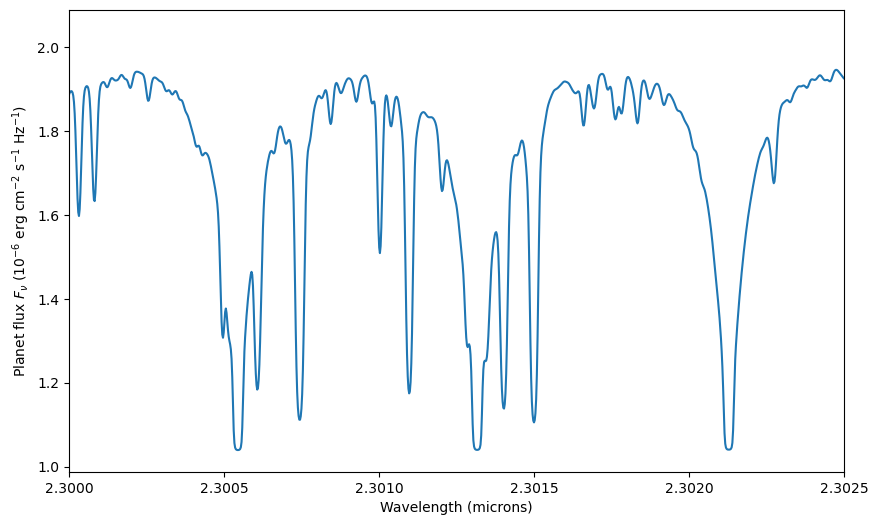

<Figure size 1000x600 with 0 Axes>

In [6]:
plt.plot(cst.c/frequencies/1e-4, flux/1e-6)

plt.xlim([2.3,2.3025])
plt.xlabel('Wavelength (microns)')
plt.ylabel(r'Planet flux $F_\nu$ (10$^{-6}$ erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$)')
plt.show()
plt.clf()